In [ ]:
# !pip install qpsolvers==2.6
# from qpsolvers import solve_qp

In [ ]:
# !pip install quadprog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
import matplotlib

# SVM Hard Margin: Aplicação no Iris dataset

In [2]:
class SVM_hardmargin():

  def __init__(self, solver ="quadprog", tol=1e-5 ):
    self.solver = solver
    self.tol = tol

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas DataFrame"

    # X = np.array(X)
    # y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = np.dot(y*X, (y*X).T)
    q = -np.ones((self.m,1)).reshape(-1,1)

    # Igualdade
    A = y.reshape(1,-1)
    b= 0.0

    # Inegualidades
    G = -np.eye(self.m)
    h = np.zeros(self.m).reshape(-1,1)

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()

    w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne

    # w = np.dot((alpha*y).reshape(1,-1), X)[0] # w precisar ter dimensao 1 x ne
    wx = np.dot(X[sv], w)

    # b = 1/self.m*(np.sum(y[sv] - wx))
    b = np.mean(y[sv] - wx)

    self.w = w
    self.b = b
    self.alpha = alpha
    self.sv = sv


  def predict(self, X_tst):
    wx = np.dot(self.w, X_tst.T)
    yhat = wx + self.b
    yhat = np.sign(yhat)
    return yhat


# w       = np.dot((y * alphas).T, X)[0]
# S       = (alphas > 1e-5).flatten()
# b       = np.mean(y[S] - np.dot(X[S], w.reshape(-1, 1)))

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])

# Retain only 2 linearly separable classes
iris_df = iris_df[iris_df["target"].isin([0,1])]
iris_df["target"] = iris_df[["target"]].replace(0,-1)

# Select only 2 attributes
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris_df.head()

petal length (cm)  petal width (cm)  target
0                1.4               0.2    -1.0
1                1.4               0.2    -1.0
2                1.3               0.2    -1.0
3                1.5               0.2    -1.0
4                1.4               0.2    -1.0

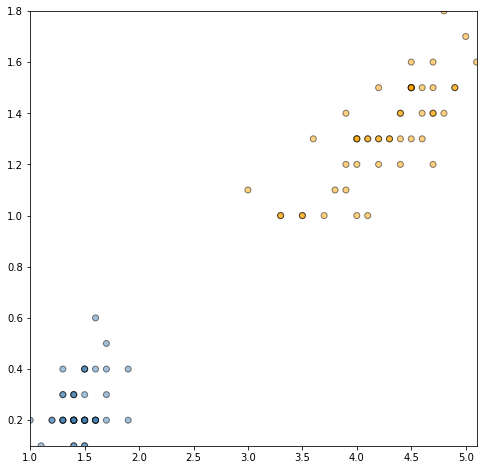

In [4]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()

plt.figure(figsize=(8, 8))
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")

x_min = min(X[:, 0])
x_max = max(X[:, 0])

y_min = min(X[:, 1])
y_max = max(X[:, 1])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [5]:
classifier = SVM_hardmargin()
classifier.fit(X,y)
print('w:', classifier.w, 'b:', classifier.b)

     pcost       dcost       gap    pres   dres
 0: -5.8693e+00 -1.1241e+01  3e+02  1e+01  2e+00
 1: -5.9277e+00 -3.6988e+00  4e+01  2e+00  3e-01
 2: -1.0647e+00 -1.9434e+00  5e+00  2e-01  2e-02
 3: -6.5979e-01 -1.1956e+00  6e-01  6e-03  8e-04
 4: -8.3813e-01 -1.2988e+00  5e-01  3e-03  4e-04
 5: -1.1588e+00 -1.1784e+00  2e-02  8e-05  1e-05
 6: -1.1763e+00 -1.1765e+00  2e-04  8e-07  1e-07
 7: -1.1765e+00 -1.1765e+00  2e-06  8e-09  1e-09
 8: -1.1765e+00 -1.1765e+00  2e-08  8e-11  1e-11
Optimal solution found.
w: [1.29411766 0.82352941] b: -3.7882353122348595


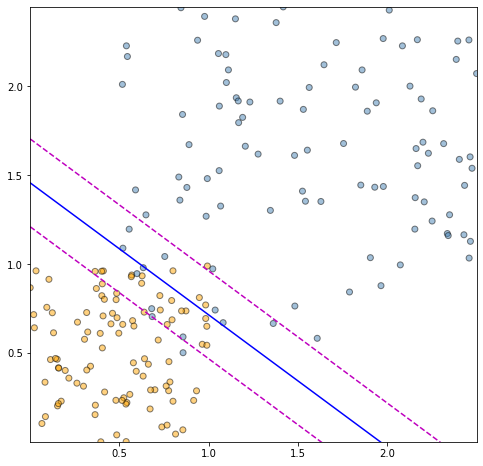

In [17]:
def plot_margin(X,classifier, title=None):

  w = classifier.w
  b = classifier.b

  x_min = min(X[:, 0])
  x_max = max(X[:, 0])

  y_min = min(X[:, 1])
  y_max = max(X[:, 1])

  xx = np.linspace(x_min, x_max)
  a = -w[0]/w[1]
  yy = a*xx - (b)/w[1]
  margin = 1 / np.sqrt(np.sum(w**2))
  yy_neg = yy - np.sqrt(1 + a**2) * margin
  yy_pos = yy + np.sqrt(1 + a**2) * margin
  plt.figure(figsize=(8, 8))
  plt.plot(xx, yy, "b-")
  plt.plot(xx, yy_neg, "m--")
  plt.plot(xx, yy_pos, "m--")
  colors = ["steelblue", "orange"]
  plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  if title is not None:
    plt.title(title)
  plt.show()

plot_margin(X, classifier)

# SVM soft margin + aplicação em duas distribuições aleatórias

In [406]:

class SVM():

  def __init__(self, C, solver ="quadprog", tol=1e-5, verbose=True):
    assert C>0, 'C precisa ser uma constante positiva'
    self.C=float(C)
    self.solver = solver
    self.tol = tol
    self.verbose=verbose
    cvxopt.solvers.options['show_progress'] = verbose

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    #assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas DataFrame"

    X = np.array(X)
    y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = np.dot(y*X, (y*X).T)
    q = -np.ones((self.m,1)).reshape(-1,1)

    # Inegualidades
    G_lb = -np.eye(self.m)
    h_lb = np.zeros(self.m).reshape(-1,1)

    G_ub = np.eye(self.m)
    h_ub = self.C*np.ones(self.m).reshape(-1,1)

    G = np.vstack((G_lb,G_ub))
    h = np.vstack((h_lb,h_ub))

    # Igualdade
    A = y.reshape(1,-1).astype(float)
    b= 0.0

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()
    w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne
    wx = np.dot(X[sv], w)
    b = np.mean(y[sv] - wx)

    self.w = w
    self.b = b
    self.alpha = alpha
    self.sv = sv


  def predict(self, X_tst):
    wx = np.dot(self.w, X_tst.T)
    yhat = wx + self.b
    yhat = np.sign(yhat)
    return yhat

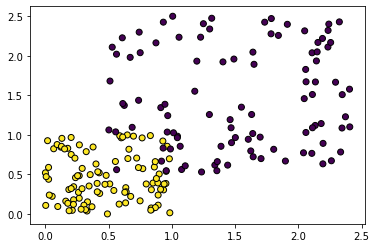

In [375]:
X1 = np.random.random([100,2])*np.array([1,1])
y1 = np.ones(100).reshape(-1,1)

X2 = np.random.random([100,2])*np.array([2,2]) + 0.5
y2 = -np.ones(100).reshape(-1,1)

X = np.vstack((X1,X2))
y  = np.vstack((y1,y2))

plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            edgecolors="black")

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -2.2588e+02 -1.5105e+04  4e+04  9e-01  7e-14
 1: -5.1068e+01 -4.7353e+03  7e+03  1e-01  6e-14
 2: -2.1054e+01 -9.2770e+02  1e+03  1e-02  4e-14
 3: -9.7531e+01 -3.9458e+02  3e+02  3e-03  4e-14
 4: -1.3671e+02 -2.9255e+02  2e+02  1e-03  5e-14
 5: -1.5450e+02 -2.5657e+02  1e+02  7e-04  4e-14
 6: -1.6929e+02 -2.1154e+02  4e+01  1e-04  4e-14
 7: -1.7522e+02 -1.9990e+02  2e+01  7e-05  5e-14
 8: -1.7828e+02 -1.9504e+02  2e+01  3e-05  5e-14
 9: -1.8421e+02 -1.8793e+02  4e+00  3e-06  5e-14
10: -1.8558e+02 -1.8586e+02  3e-01  2e-07  6e-14
11: -1.8569e+02 -1.8571e+02  2e-02  1e-08  6e-14
12: -1.8570e+02 -1.8570e+02  2e-04  1e-10  6e-14
13: -1.8570e+02 -1.8570e+02  2e-06  1e-12  4e-14
Optimal solution found.


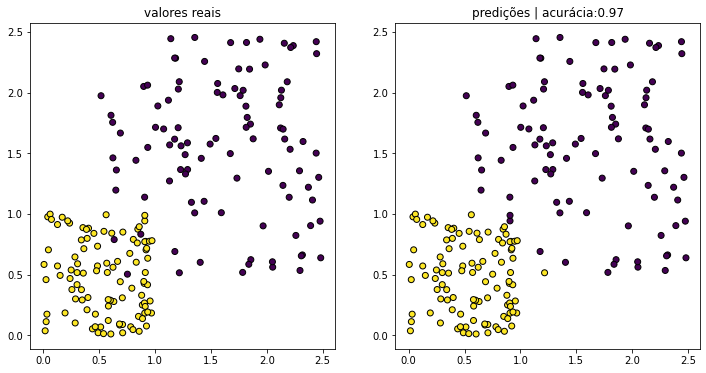

In [274]:
def pipeline_SVM(model):
  classifier = model
  alphas = classifier.fit(X,y)
  ypred = classifier.predict(X)

  fig, axis = plt.subplots(1,2, figsize=(12,6))

  axis[0].scatter(X[:, 0],
                  X[:, 1],
                  c=y,
                  edgecolors="black")
  axis[0].set_title('valores reais')

  axis[1].scatter(X[:, 0],
                  X[:, 1],
                  c=ypred,
                  edgecolors="black")
  axis[1].set_title('predições | acurácia:{}'.format(np.mean(y.flatten()==ypred.flatten())))

C=10
pipeline_SVM(SVM(C=C))

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -2.5432e+01 -8.7282e-01  1e+03  4e+01  7e-15
 1: -8.9661e-01 -8.5096e-01  2e+01  5e-01  5e-15
 2: -3.9143e-01 -5.1015e-01  2e+00  6e-02  9e-16
 3: -1.6010e-01 -3.9598e-01  2e-01  1e-17  1e-15
 4: -1.7838e-01 -1.9671e-01  2e-02  1e-17  5e-16
 5: -1.8859e-01 -1.8882e-01  2e-04  6e-18  4e-16
 6: -1.8872e-01 -1.8873e-01  2e-06  2e-17  3e-16
 7: -1.8872e-01 -1.8872e-01  2e-08  4e-18  3e-16
Optimal solution found.


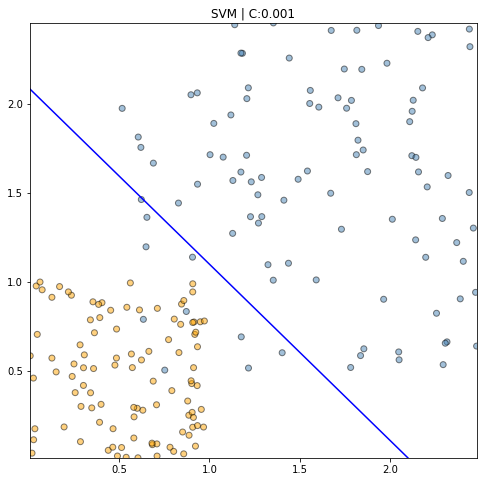

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -2.5656e+01 -4.3419e+00  1e+03  4e+01  6e-15
 1: -1.0919e+00 -4.3212e+00  1e+01  3e-01  6e-15
 2: -8.9548e-01 -2.8446e+00  2e+00  3e-16  6e-16
 3: -1.0019e+00 -1.2665e+00  3e-01  2e-16  6e-16
 4: -1.0964e+00 -1.1500e+00  5e-02  9e-17  5e-16
 5: -1.1199e+00 -1.1287e+00  9e-03  4e-17  5e-16
 6: -1.1238e+00 -1.1250e+00  1e-03  1e-16  6e-16
 7: -1.1244e+00 -1.1244e+00  4e-05  2e-16  5e-16
 8: -1.1244e+00 -1.1244e+00  4e-07  1e-16  6e-16
Optimal solution found.


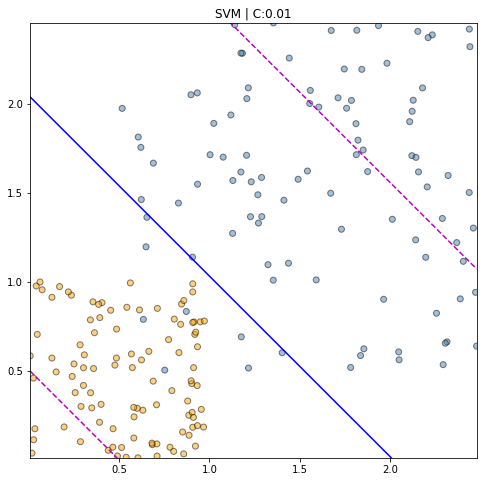

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -2.7894e+01 -3.8900e+01  1e+03  3e+01  7e-15
 1: -5.1602e+00 -3.6171e+01  8e+01  1e+00  6e-15
 2: -3.0902e+00 -1.4761e+01  1e+01  2e-03  2e-15
 3: -4.0190e+00 -5.9312e+00  2e+00  3e-04  1e-15
 4: -4.5474e+00 -5.0653e+00  5e-01  5e-05  1e-15
 5: -4.6964e+00 -4.8471e+00  2e-01  1e-05  1e-15
 6: -4.7464e+00 -4.7770e+00  3e-02  1e-06  2e-15
 7: -4.7588e+00 -4.7616e+00  3e-03  2e-09  2e-15
 8: -4.7601e+00 -4.7602e+00  4e-05  2e-11  2e-15
 9: -4.7602e+00 -4.7602e+00  4e-07  2e-13  2e-15
Optimal solution found.


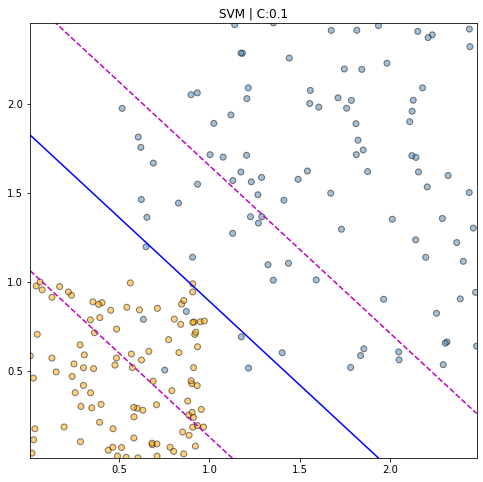

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -4.9840e+01 -4.3915e+02  2e+03  3e+00  1e-14
 1: -3.0256e+01 -2.6181e+02  4e+02  3e-01  9e-15
 2: -1.7430e+01 -6.3644e+01  6e+01  4e-02  7e-15
 3: -2.0983e+01 -3.3125e+01  1e+01  8e-03  7e-15
 4: -2.2846e+01 -2.8808e+01  7e+00  3e-03  6e-15
 5: -2.3988e+01 -2.6543e+01  3e+00  1e-03  7e-15
 6: -2.4593e+01 -2.5594e+01  1e+00  3e-04  7e-15
 7: -2.4841e+01 -2.5175e+01  3e-01  2e-05  8e-15
 8: -2.4989e+01 -2.5004e+01  2e-02  8e-07  8e-15
 9: -2.4996e+01 -2.4997e+01  2e-04  9e-09  8e-15
10: -2.4997e+01 -2.4997e+01  2e-06  9e-11  9e-15
Optimal solution found.


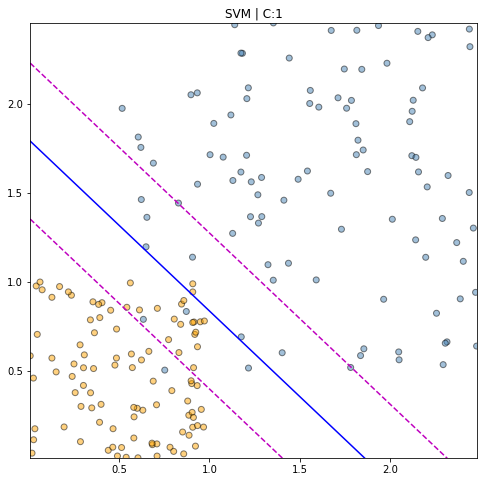

(1, 200)
     pcost       dcost       gap    pres   dres
 0: -2.2588e+02 -1.5105e+04  4e+04  9e-01  7e-14
 1: -5.1068e+01 -4.7353e+03  7e+03  1e-01  6e-14
 2: -2.1054e+01 -9.2770e+02  1e+03  1e-02  4e-14
 3: -9.7531e+01 -3.9458e+02  3e+02  3e-03  4e-14
 4: -1.3671e+02 -2.9255e+02  2e+02  1e-03  5e-14
 5: -1.5450e+02 -2.5657e+02  1e+02  7e-04  4e-14
 6: -1.6929e+02 -2.1154e+02  4e+01  1e-04  4e-14
 7: -1.7522e+02 -1.9990e+02  2e+01  7e-05  5e-14
 8: -1.7828e+02 -1.9504e+02  2e+01  3e-05  5e-14
 9: -1.8421e+02 -1.8793e+02  4e+00  3e-06  5e-14
10: -1.8558e+02 -1.8586e+02  3e-01  2e-07  6e-14
11: -1.8569e+02 -1.8571e+02  2e-02  1e-08  6e-14
12: -1.8570e+02 -1.8570e+02  2e-04  1e-10  6e-14
13: -1.8570e+02 -1.8570e+02  2e-06  1e-12  4e-14
Optimal solution found.


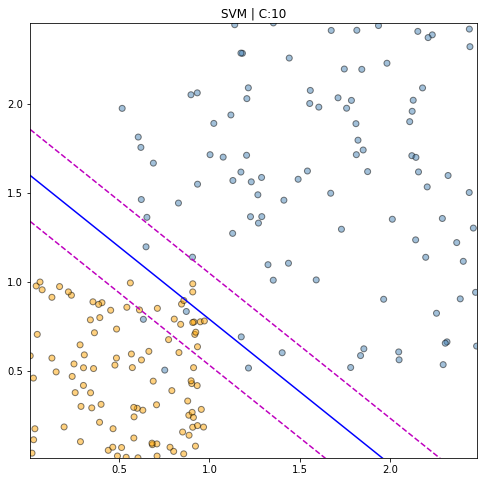

(1, 200)
     pcost       dcost       gap    pres   dres
 0:  2.3548e+03 -1.2228e+06  3e+06  7e-01  6e-13
 1:  1.1138e+04 -3.2237e+05  5e+05  7e-02  6e-13
 2:  7.6747e+03 -7.1287e+04  1e+05  1e-02  4e-13
 3:  1.2633e+03 -1.6449e+04  2e+04  1e-03  3e-13
 4: -6.3650e+02 -5.8445e+03  5e+03  3e-04  3e-13
 5: -1.0383e+03 -3.4701e+03  2e+03  1e-04  3e-13
 6: -1.1698e+03 -3.3008e+03  2e+03  1e-04  4e-13
 7: -1.2893e+03 -2.9435e+03  2e+03  7e-05  4e-13
 8: -1.3921e+03 -2.3136e+03  9e+02  2e-05  5e-13
 9: -1.4794e+03 -2.2672e+03  8e+02  1e-05  4e-13
10: -1.5638e+03 -2.0417e+03  5e+02  4e-06  4e-13
11: -1.5715e+03 -2.0083e+03  4e+02  4e-06  4e-13
12: -1.6201e+03 -1.9075e+03  3e+02  2e-06  3e-13
13: -1.6902e+03 -1.7831e+03  9e+01  2e-13  5e-13
14: -1.7288e+03 -1.7321e+03  3e+00  4e-14  5e-13
15: -1.7300e+03 -1.7300e+03  3e-02  6e-14  6e-13
16: -1.7300e+03 -1.7300e+03  3e-04  1e-13  5e-13
Optimal solution found.


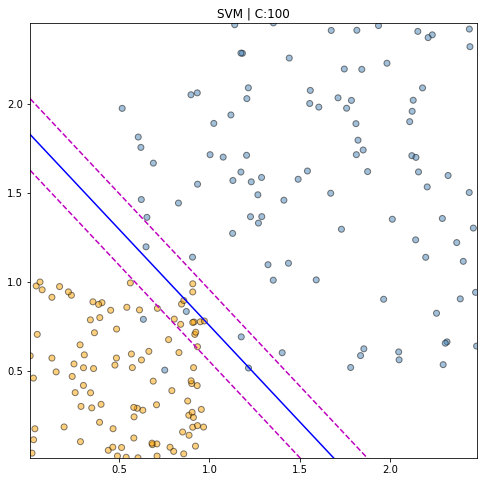

(1, 200)
     pcost       dcost       gap    pres   dres
 0:  4.6228e+05 -1.1941e+08  3e+08  7e-01  6e-12
 1:  1.2516e+06 -3.0787e+07  5e+07  7e-02  5e-12
 2:  8.4647e+05 -6.9374e+06  1e+07  1e-02  3e-12
 3:  2.0861e+05 -1.5220e+06  2e+06  1e-03  3e-12
 4:  1.0884e+04 -2.8832e+05  3e+05  1e-04  3e-12
 5: -7.5319e+03 -8.8488e+04  8e+04  2e-05  3e-12
 6: -9.8927e+03 -7.0183e+04  6e+04  2e-05  3e-12
 7: -1.0506e+04 -4.0513e+04  3e+04  1e-06  4e-12
 8: -1.1703e+04 -3.9323e+04  3e+04  1e-06  4e-12
 9: -1.3123e+04 -2.9355e+04  2e+04  4e-07  4e-12
10: -1.2781e+04 -2.5984e+04  1e+04  2e-07  4e-12
11: -1.3616e+04 -2.6195e+04  1e+04  2e-07  4e-12
12: -1.5147e+04 -2.2248e+04  7e+03  4e-08  4e-12
13: -1.5504e+04 -2.0775e+04  5e+03  2e-08  5e-12
14: -1.5885e+04 -1.9714e+04  4e+03  1e-08  4e-12
15: -1.6118e+04 -1.8870e+04  3e+03  7e-09  4e-12
16: -1.6357e+04 -1.8206e+04  2e+03  1e-09  5e-12
17: -1.6750e+04 -1.7487e+04  7e+02  3e-10  6e-12
18: -1.7055e+04 -1.7066e+04  1e+01  4e-12  5e-12
19: -1.7059e

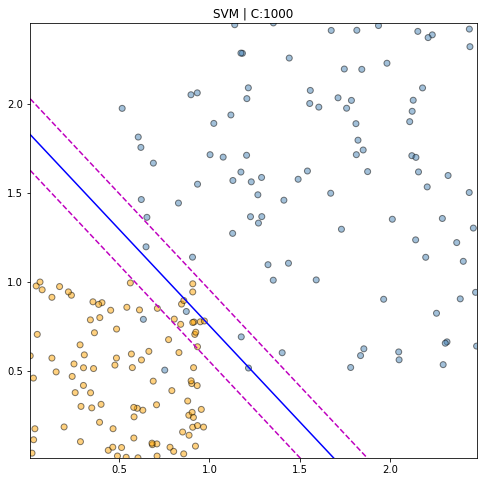

(1, 200)
     pcost       dcost       gap    pres   dres
 0:  4.8473e+07 -1.1912e+10  3e+10  7e-01  6e-11
 1:  1.2651e+08 -3.0643e+09  5e+09  7e-02  9e-10
 2:  8.5412e+07 -6.9161e+08  1e+09  1e-02  2e-10
 3:  2.1606e+07 -1.5070e+08  2e+08  1e-03  3e-11
 4:  1.8323e+06 -2.8464e+07  3e+07  1e-04  2e-11
 5: -5.8531e+04 -2.4922e+06  2e+06  5e-06  3e-11
 6: -8.8603e+04 -8.6903e+05  8e+05  1e-06  2e-11
 7: -1.0693e+05 -6.9933e+05  6e+05  9e-07  3e-11
 8: -1.0429e+05 -4.0852e+05  3e+05  3e-08  4e-11
 9: -1.1921e+05 -4.0880e+05  3e+05  2e-08  4e-11
10: -1.3021e+05 -2.9809e+05  2e+05  9e-09  4e-11
11: -1.3008e+05 -2.5897e+05  1e+05  5e-09  4e-11
12: -1.3835e+05 -2.6425e+05  1e+05  4e-09  4e-11
13: -1.4908e+05 -2.3202e+05  8e+04  1e-09  4e-11
14: -1.5595e+05 -2.0841e+05  5e+04  5e-10  4e-11
15: -1.5843e+05 -2.0289e+05  4e+04  3e-10  4e-11
16: -1.5812e+05 -1.9409e+05  4e+04  1e-10  4e-11
17: -1.6214e+05 -1.8512e+05  2e+04  7e-11  4e-11
18: -1.6500e+05 -1.7797e+05  1e+04  2e-11  5e-11
19: -1.6971e

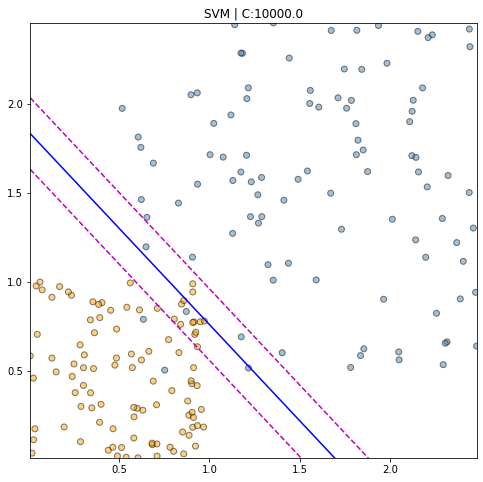

(1, 200)
     pcost       dcost       gap    pres   dres
 0:  4.8697e+09 -1.1909e+12  3e+12  7e-01  6e-10
 1:  1.2664e+10 -3.0629e+11  5e+11  7e-02  1e-07
 2:  8.5488e+09 -6.9140e+10  1e+11  1e-02  3e-08
 3:  2.1680e+09 -1.5054e+10  2e+10  1e-03  3e-09
 4:  1.8940e+08 -2.8307e+09  3e+09  9e-05  3e-10
 5:  4.6821e+05 -1.6850e+08  2e+08  2e-06  2e-10
 6: -8.1014e+05 -1.1198e+07  1e+07  1e-07  2e-10
 7: -9.8175e+05 -9.2999e+06  8e+06  8e-08  2e-10
 8: -1.0894e+06 -7.4992e+06  6e+06  5e-08  3e-10
 9: -1.0888e+06 -3.2242e+06  2e+06  2e-09  4e-10
10: -1.2225e+06 -3.2250e+06  2e+06  2e-09  4e-10
11: -1.3540e+06 -2.8503e+06  1e+06  9e-10  4e-10
12: -1.2711e+06 -2.4988e+06  1e+06  3e-10  4e-10
13: -1.4184e+06 -2.3924e+06  1e+06  1e-10  4e-10
14: -1.5095e+06 -2.1423e+06  6e+05  6e-11  4e-10
15: -1.5233e+06 -2.1131e+06  6e+05  1e-10  3e-10
16: -1.5470e+06 -2.0271e+06  5e+05  2e-10  4e-10
17: -1.5658e+06 -1.9978e+06  4e+05  7e-11  4e-10
18: -1.5486e+06 -1.9638e+06  4e+05  3e-10  4e-10
19: -1.5758e

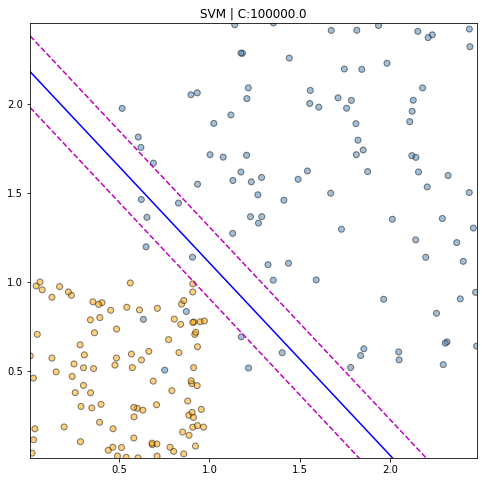

In [276]:
def test_SVMs(list_C):
  for C in list_C:
    classifier = SVM(C=C)
    alphas = classifier.fit(X,y)
    ypred = classifier.predict(X)
    plot_margin(X, classifier, title='SVM | C:{}'.format(C))

test_SVMs([0.001,0.01, 0.1, 1,10,100,1000,1e4,1e5])

In [277]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(1, 160)
     pcost       dcost       gap    pres   dres
 0: -1.5956e+02 -1.1799e+04  3e+04  8e-01  4e-14
 1: -4.9321e+00 -3.6408e+03  5e+03  1e-01  3e-14
 2:  1.7972e+01 -7.3582e+02  1e+03  1e-02  2e-14
 3: -4.6791e+01 -2.9481e+02  3e+02  3e-03  1e-14
 4: -8.4088e+01 -1.9076e+02  1e+02  1e-03  1e-14
 5: -9.9018e+01 -1.5785e+02  6e+01  4e-04  1e-14
 6: -1.0747e+02 -1.4136e+02  3e+01  2e-04  1e-14
 7: -1.1275e+02 -1.3115e+02  2e+01  9e-05  2e-14
 8: -1.1694e+02 -1.2548e+02  9e+00  1e-05  2e-14
 9: -1.2030e+02 -1.2069e+02  4e-01  6e-07  2e-14
10: -1.2046e+02 -1.2046e+02  4e-03  7e-09  2e-14
11: -1.2046e+02 -1.2046e+02  4e-05  7e-11  2e-14
Optimal solution found.


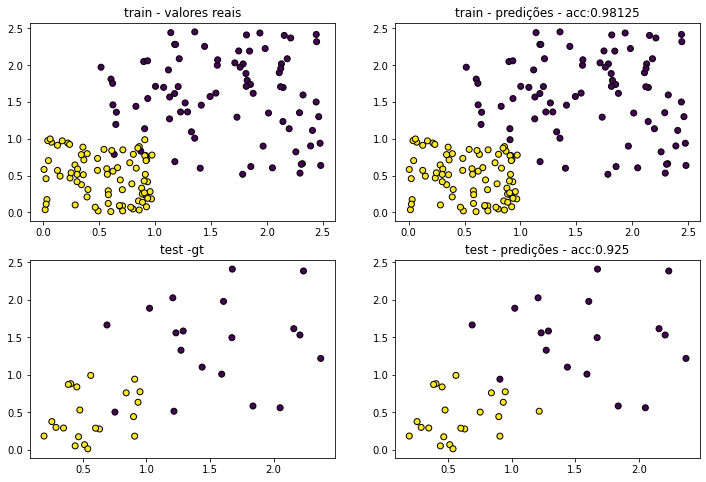

In [292]:
def train_svm_and_plot(C):

  classifier = SVM(C=C)
  alphas = classifier.fit(X_train,y_train)

  ypred_train = classifier.predict(X_train)
  ypred_test = classifier.predict(X_test)

  fig, axis = plt.subplots(2,2, figsize=(12,8))

  axis[0,0].scatter(X_train[:, 0],
              X_train[:, 1],
              c=y_train.astype(int),
              edgecolors="black")
  axis[0,0].set_title('train - valores reais')

  axis[0,1].scatter(X_train[:, 0],
              X_train[:, 1],
              c=ypred_train.astype(int),
              edgecolors="black")

  axis[0,1].set_title('train - predições - acc:{}'.format(np.mean(y_train.flatten()==ypred_train.flatten())))


  axis[1,0].scatter(X_test[:, 0],
              X_test[:, 1],
              c=y_test.astype(int),
              edgecolors="black")

  axis[1,0].set_title('test -gt')


  axis[1,1].scatter(X_test[:, 0],
              X_test[:, 1],
              c=ypred_test.astype(int),
              edgecolors="black")
  axis[1,1].set_title('test - predições - acc:{}'.format(np.mean(y_test.flatten()==ypred_test.flatten())))


train_svm_and_plot(C=10)

# SVM soft margin e kernel + aplicação em distribuições aleatórias 

---



In [454]:
class SVM_kernel():

  def __init__(self, C, kernel_type='poly', kernel_params=None, solver ="quadprog", tol=1e-5, verbose=False ):
    assert C>0, 'C precisa ser uma constante positiva'
    self.C=float(C)
    self.kernel_type = kernel_type
    self.kernel_params = kernel_params
    self.solver = solver
    self.tol = tol
    self.verbose=verbose
    cvxopt.solvers.options['show_progress'] = verbose

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    # assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas numpy arrays"

    X = np.array(X)
    y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = self.calculate_kernel()

    q = -np.ones((self.m,1)).reshape(-1,1)

    # Inegualidades
    G_lb = -np.eye(self.m)
    h_lb = np.zeros(self.m).reshape(-1,1)

    G_ub = np.eye(self.m)
    h_ub = self.C*np.ones(self.m).reshape(-1,1)

    G = np.vstack((G_lb,G_ub))
    h = np.vstack((h_lb,h_ub))

    # Igualdade
    A = y.reshape(1,-1).astype(float)
    b = 0.0

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b, show_progress=False) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()
    self.alpha = alpha
    self.sv = sv

    # w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne
    # wx = np.dot(X[sv], w)
    # b = np.mean(y[sv] - wx)
    # self.w = w
    # self.b = b



  def check_param(self, param):
    assert param in self.kernel_params.keys(), 'se o kernel é {} é necessário ter declarado o parametro {}'.format(self.kernel_type,param)

  def calculate_kernel(self):

    assert isinstance(self.kernel_params, dict), 'kernel_params precisa ser um dicionario'
    assert self.kernel_type in ['poly', 'rbf'], 'kernel_type precisa ser poly ou rbf'

    K = np.zeros((self.m, self.m))
    H = np.zeros((self.m, self.m))

    if self.kernel_type=='poly':
      self.check_param('d')
      d = self.kernel_params['d']

      for i in range(0, self.m):
        for j in range(0, self.m):
          K[i,j] = (self.X[i,:]@self.X[j,:]+1)**d
          H[i,j] = K[i,j]*self.y[i,0]*self.y[j,0]

      return H

    elif self.kernel_type=='rbf':
      self.check_param('sigma')
      sigma = self.kernel_params['sigma']

      for i in range(0, self.m):
        for j in range(0, self.m):
          K[i,j] = np.exp(-np.linalg.norm(self.X[i,:] - self.X[j,:])**2/(2*sigma**2))
          H[i,j] = K[i,j]*self.y[i,0]*self.y[j,0]
          
      return H
      

  def predict(self, X_tst):

    X_tst = np.array(X_tst)
    m_test = X_tst.shape[0]

    alphasv = self.alpha[self.sv]
    Xsv = self.X[self.sv,:]
    ysv = self.y[self.sv,:]
    m_sv = Xsv.shape[0]

    K = np.zeros((m_sv, m_test))

    for i in range(0, m_sv):
      for j in range(0, m_test):
        if self.kernel_type=='poly':
          K[i,j] = (Xsv[i,:] @ X_tst[j,:]+1)**self.kernel_params['d']

        elif self.kernel_type=='rbf':
          # print(Xsv[i,:])
          # print(X_tst[j,:])
          K[i,j] = np.exp(-np.linalg.norm(Xsv[i,:].flatten() - X_tst[j,:].flatten())**2/(2*self.kernel_params['sigma']**2))
          


    yhat = np.sign((alphasv * ysv).T@K)

    return yhat

     pcost       dcost       gap    pres   dres
 0:  2.9517e+03 -5.2059e+05  9e+05  2e-01  8e-11
 1:  9.1326e+02 -8.5026e+04  1e+05  3e-02  7e-11
 2: -4.2552e+02 -3.3902e+04  4e+04  7e-03  4e-11
 3: -7.4475e+02 -1.3886e+04  2e+04  2e-03  3e-11
 4: -8.1732e+02 -6.2505e+03  6e+03  6e-04  3e-11
 5: -1.0688e+03 -3.2179e+03  2e+03  2e-04  3e-11
 6: -1.2474e+03 -2.1847e+03  1e+03  3e-05  3e-11
 7: -1.3792e+03 -1.7237e+03  4e+02  9e-06  3e-11
 8: -1.4048e+03 -1.6753e+03  3e+02  6e-06  3e-11
 9: -1.4540e+03 -1.5655e+03  1e+02  2e-06  3e-11
10: -1.4822e+03 -1.5111e+03  3e+01  1e-07  3e-11
11: -1.4914e+03 -1.4962e+03  5e+00  2e-08  4e-11
12: -1.4932e+03 -1.4937e+03  5e-01  7e-13  4e-11
13: -1.4935e+03 -1.4935e+03  8e-03  6e-13  5e-11
14: -1.4935e+03 -1.4935e+03  8e-05  6e-14  4e-11
Optimal solution found.


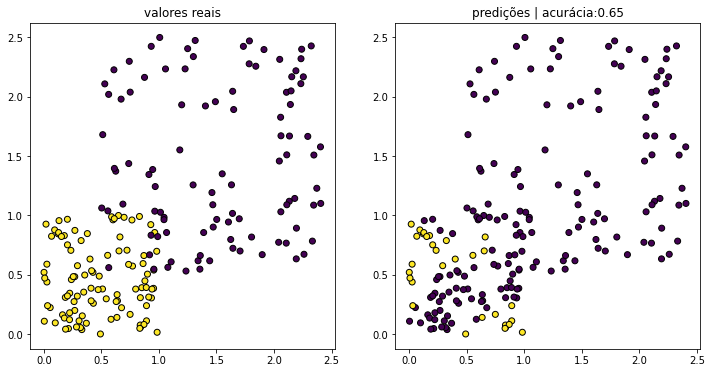

In [377]:
C=100

model = SVM_kernel(C=C, kernel_type='poly', kernel_params={'d':4}, verbose=True)

pipeline_SVM(model)

sigma:0.001 C:1


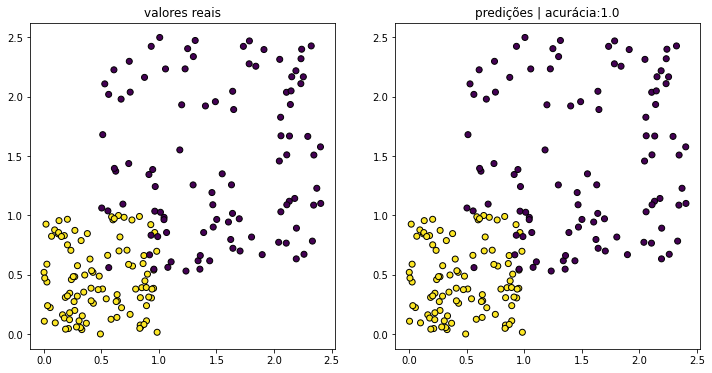

sigma:0.001 C:10


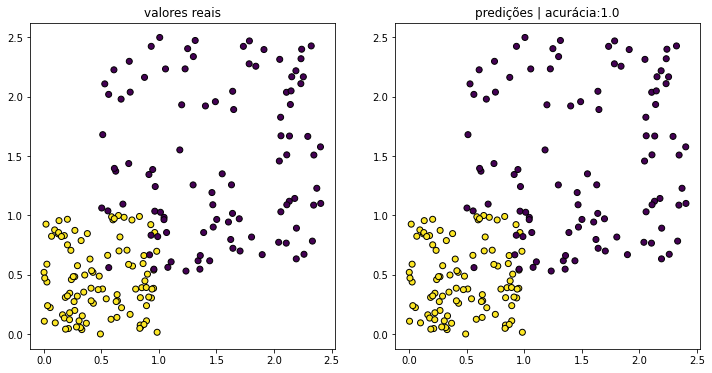

sigma:0.001 C:100


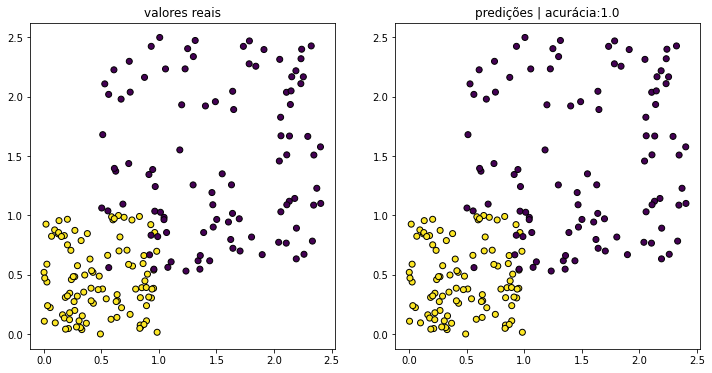

sigma:0.001 C:1000


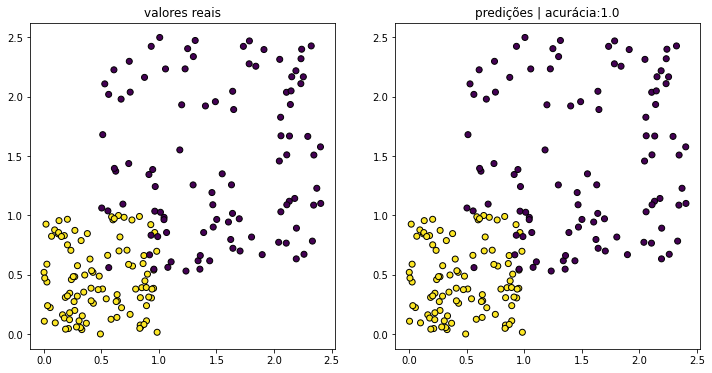

sigma:0.001 C:10000


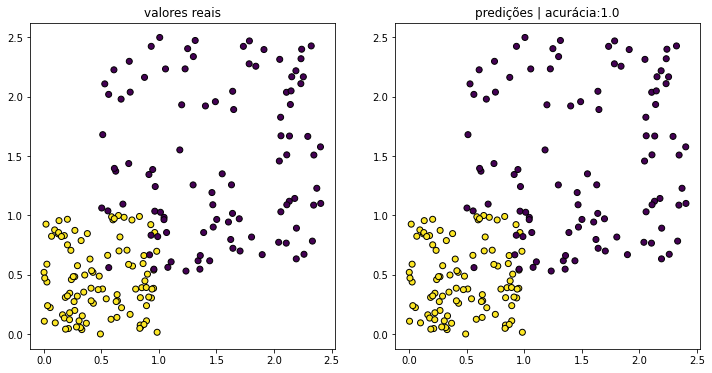

sigma:0.001 C:100000


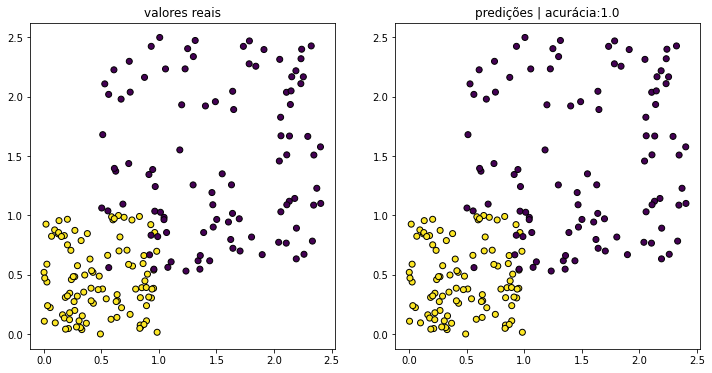

sigma:0.01 C:1


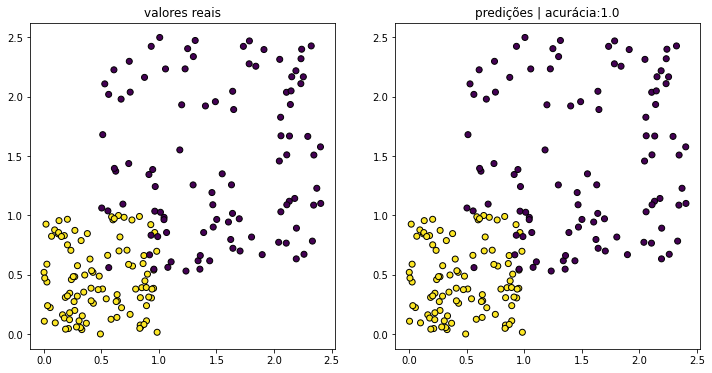

sigma:0.01 C:10


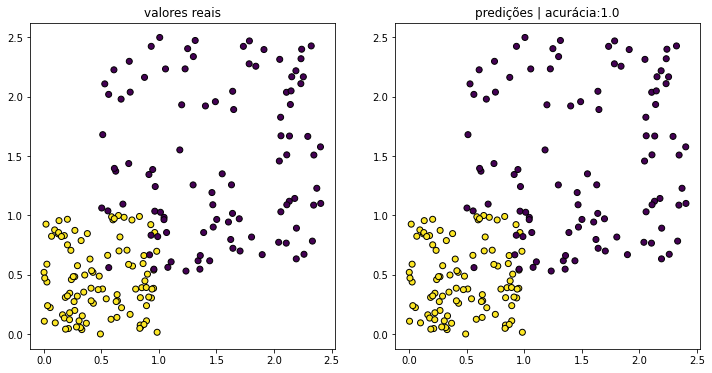

sigma:0.01 C:100


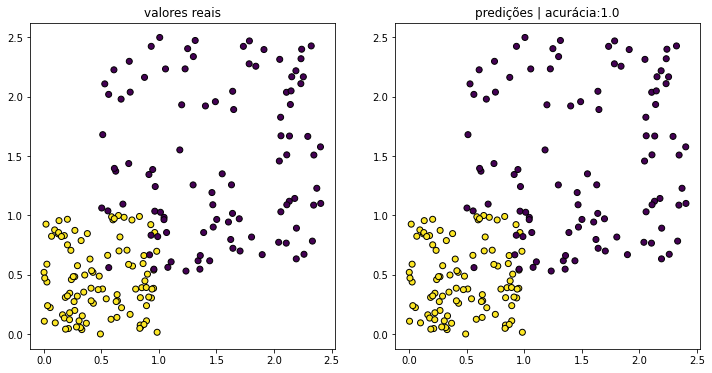

sigma:0.01 C:1000


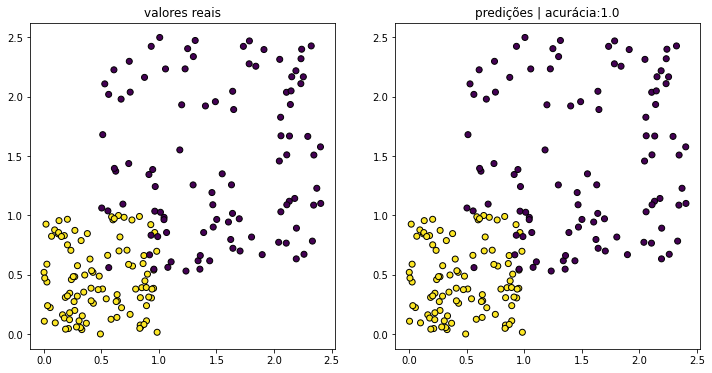

sigma:0.01 C:10000


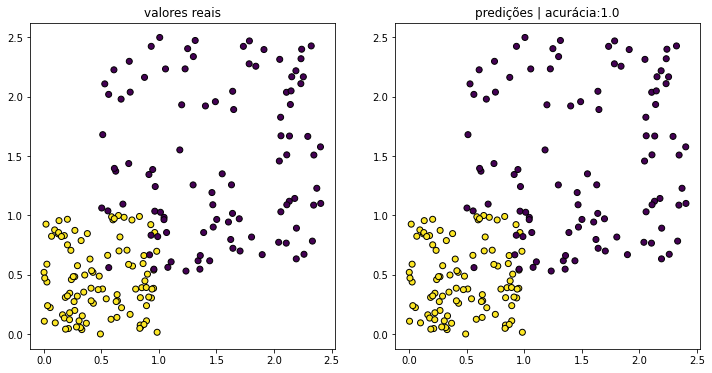

sigma:0.01 C:100000


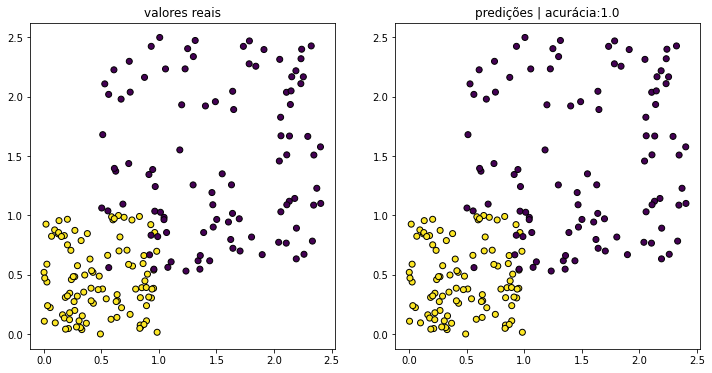

sigma:0.1 C:1


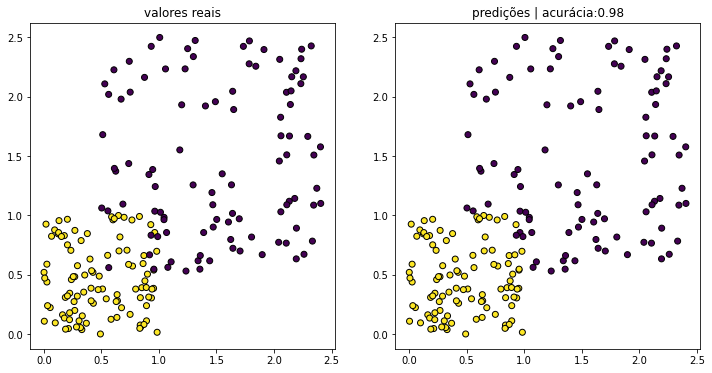

sigma:0.1 C:10


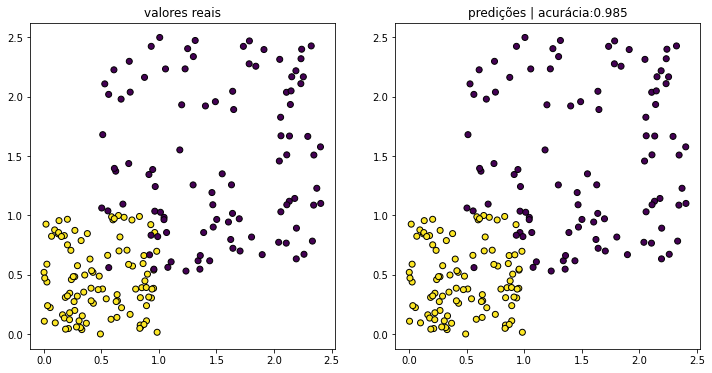

sigma:0.1 C:100


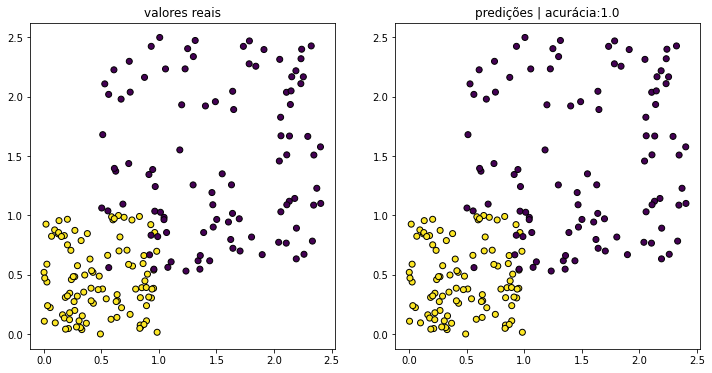

sigma:0.1 C:1000


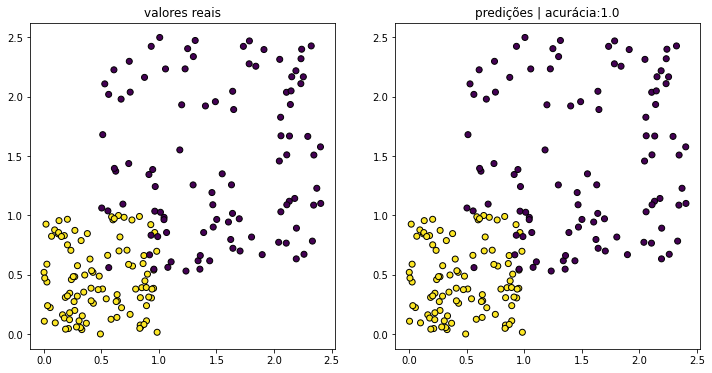

sigma:0.1 C:10000


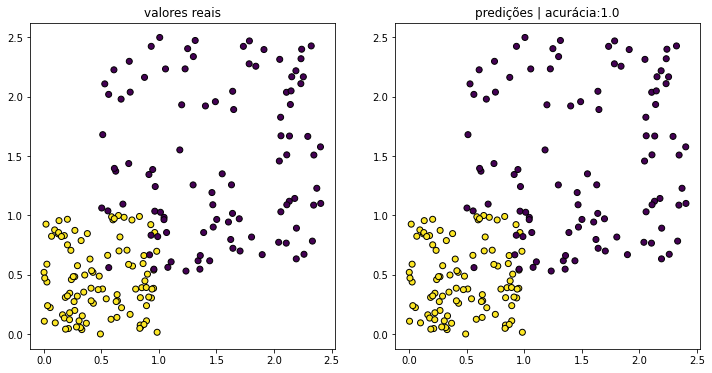

sigma:0.1 C:100000


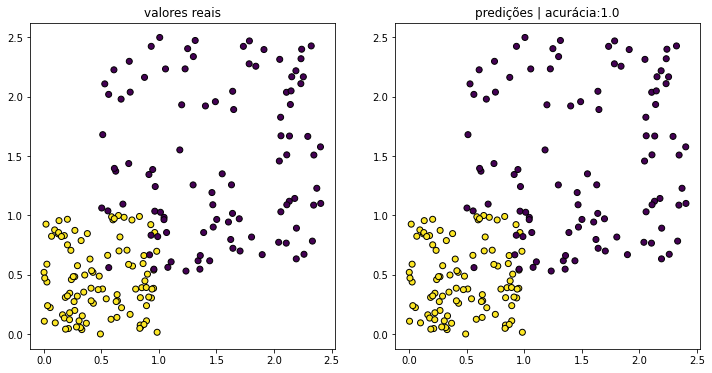

sigma:1 C:1


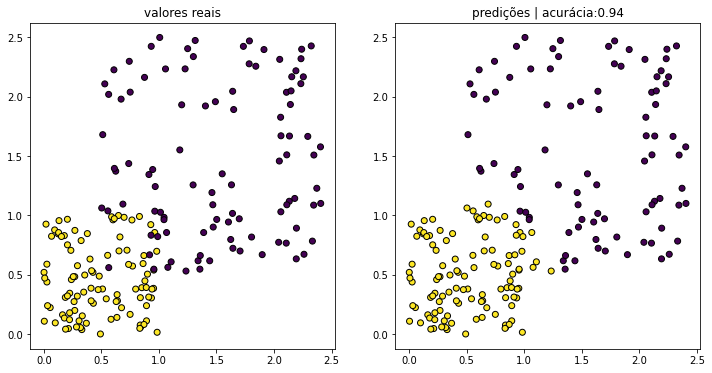

sigma:1 C:10


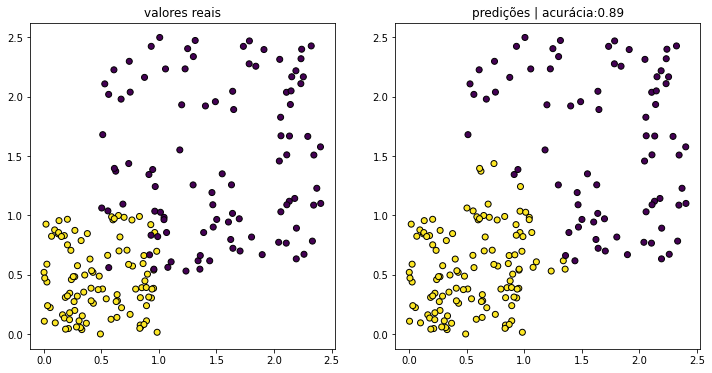

sigma:1 C:100


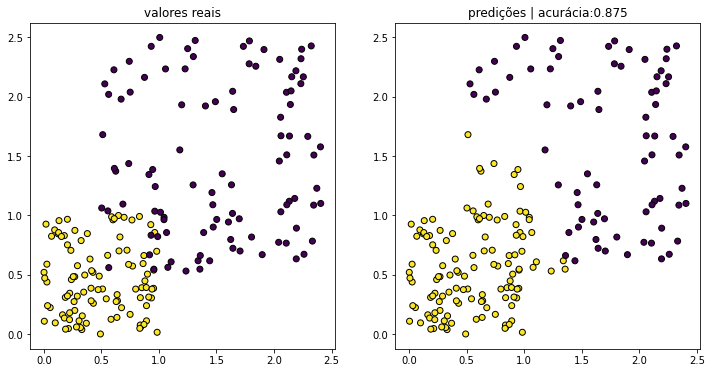

sigma:1 C:1000


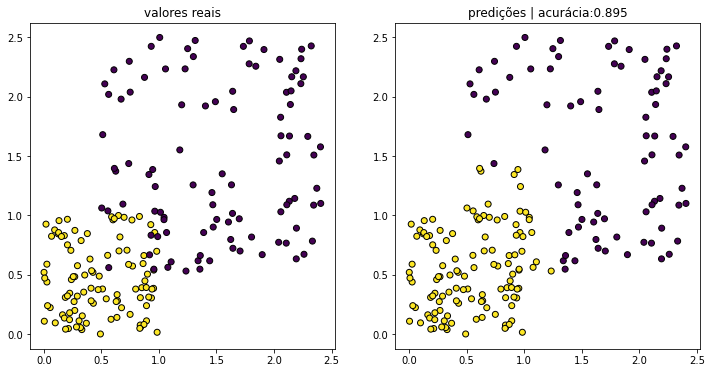

sigma:1 C:10000


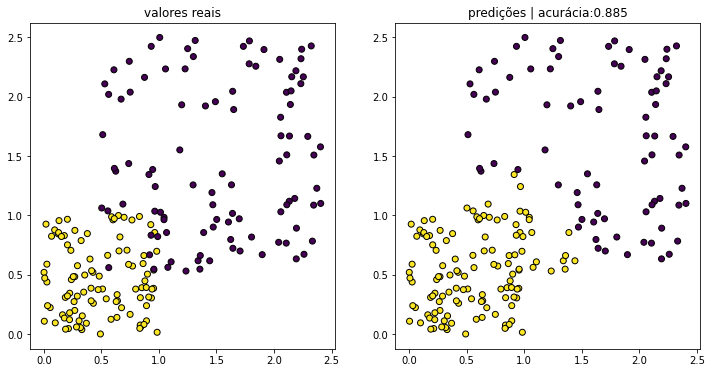

sigma:1 C:100000


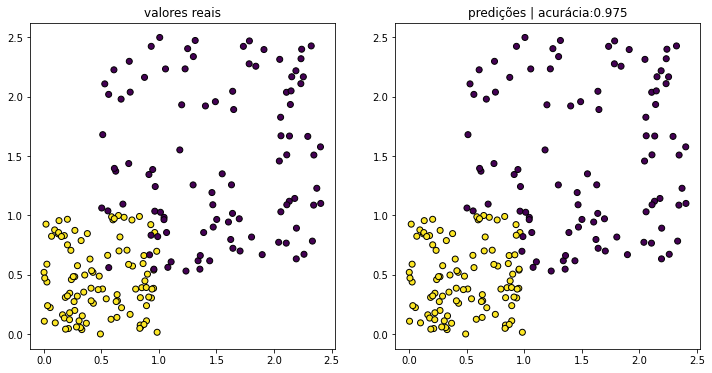

sigma:10 C:1


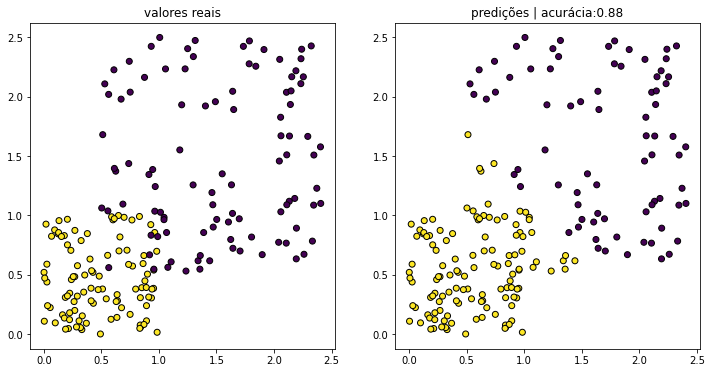

sigma:10 C:10


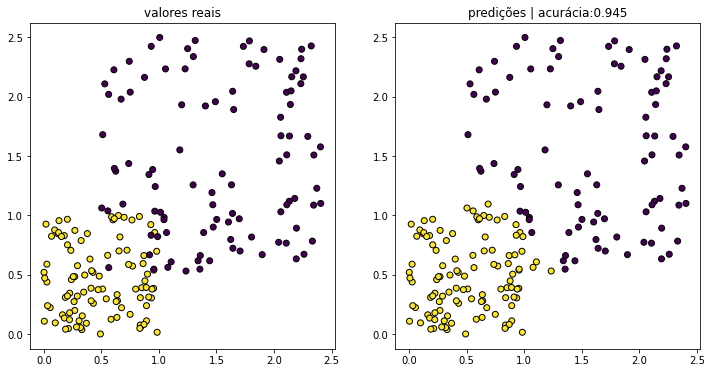

sigma:10 C:100


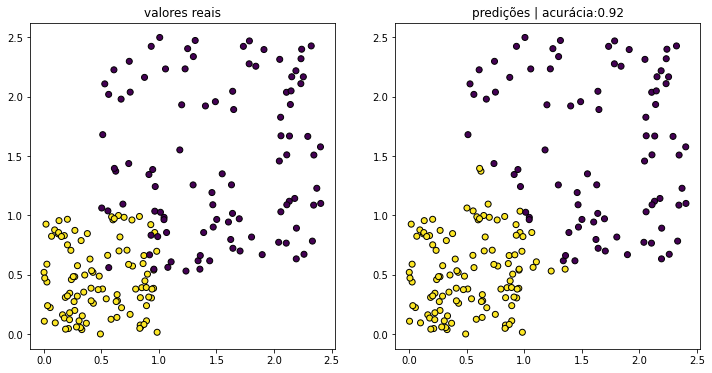

sigma:10 C:1000


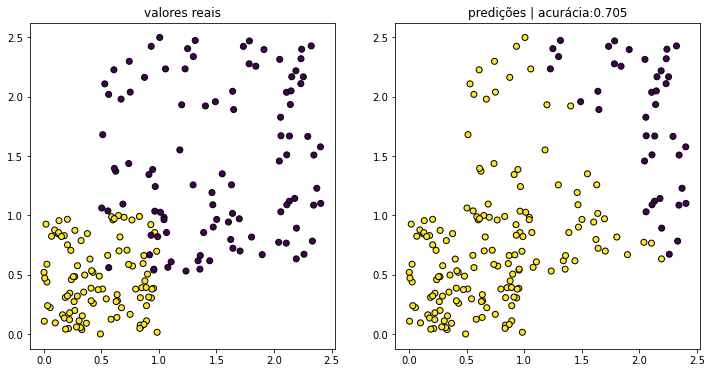

sigma:10 C:10000


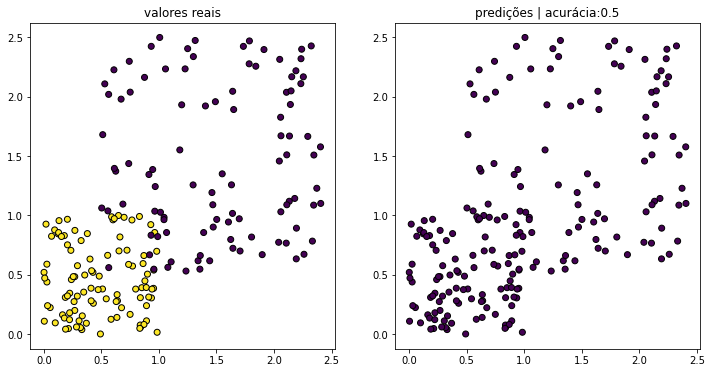

sigma:10 C:100000


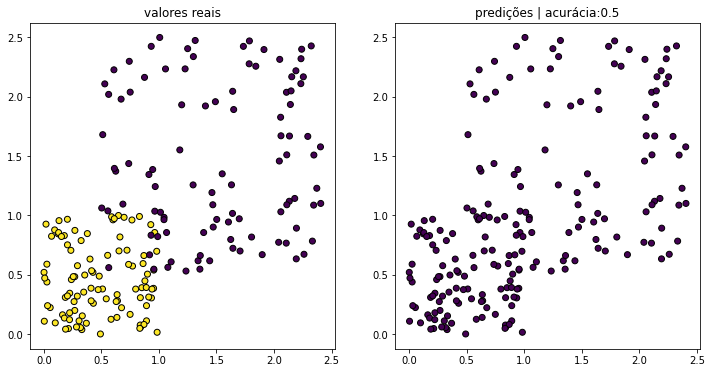

sigma:100 C:1


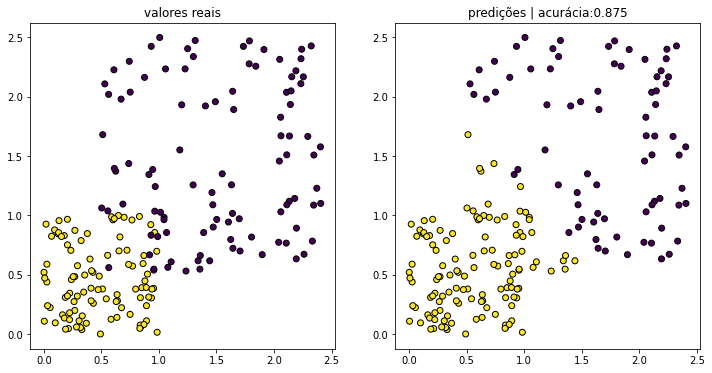

sigma:100 C:10


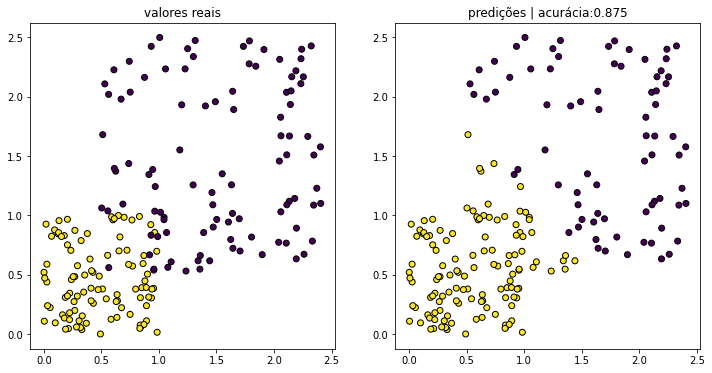

sigma:100 C:100


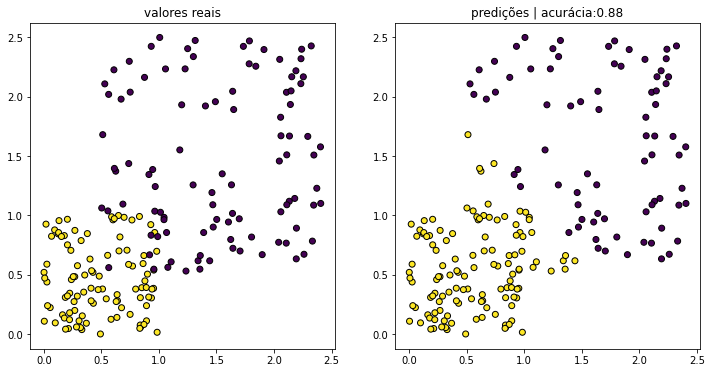

sigma:100 C:1000


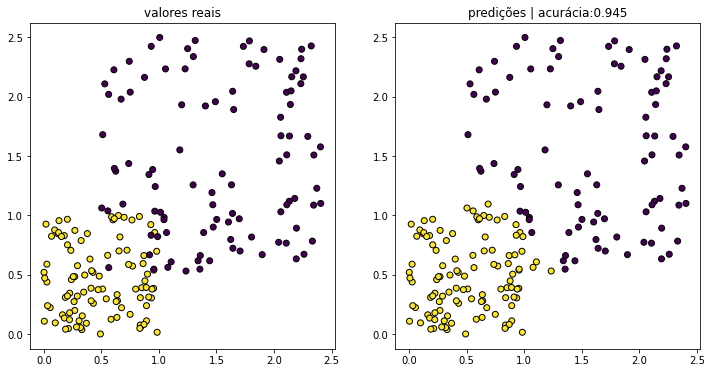

sigma:100 C:10000


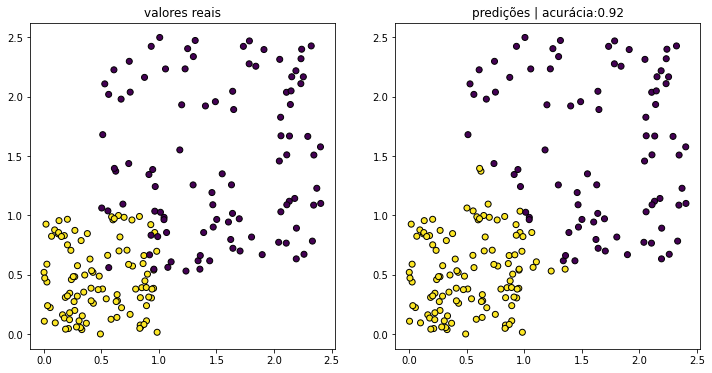

sigma:100 C:100000


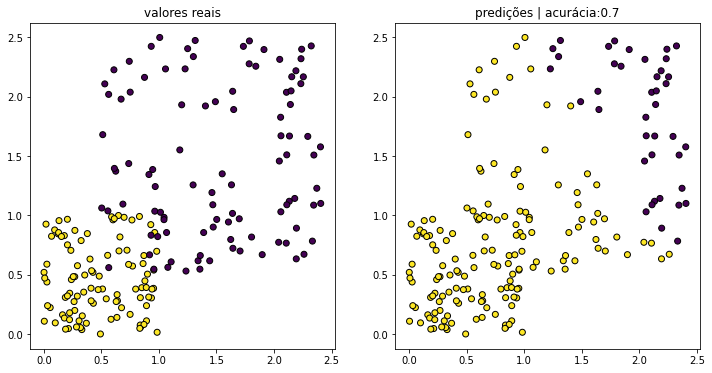

In [378]:
for sigma in [.001,.01, .1, 1, 10, 100]:
  for C in [1,10,100,1000,10000,100000]:
    print('sigma:{} C:{}'.format(sigma,C))
    model = SVM_kernel(C=C, kernel_type='rbf', kernel_params={'sigma':sigma})
    pipeline_SVM(model)
    plt.show()

# SVM soft margin e kernel + aplicação em cancer dataset


In [379]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns= cancer.feature_names)
y = pd.DataFrame(cancer.target, columns= ['target'])
y['target'] = y['target'].apply(lambda x:2*x-1)
m = X.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = (X_test - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_train = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))

In [441]:
print('X:',X.shape)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X: (569, 30)
X_train: (455, 30)
y_train: (455, 1)
X_test: (114, 30)
y_test: (114, 1)


In [427]:
# from sklearn.svm import LinearSVC

# classifier = LinearSVC(random_state=0, tol=1e-5)
# classifier.fit(X_train,y_train)

# ypred_train = classifier.predict(X_train)
# ypred_test = classifier.predict(X_test)
# print('acuracia treino:{} acuracia teste:{}'.format(np.mean(ypred_train.flatten()==y_train.values.flatten()), np.mean(ypred_test.flatten()==y_test.values.flatten())))

In [461]:
# from sklearn.svm import SVC

# classifier = SVC(gamma='auto')
# classifier.fit(X_train,y_train)

# ypred_train = classifier.predict(X_train)
# ypred_test = classifier.predict(X_test)

# print('acuracia treino:{} acuracia teste:{}'.format(np.mean(ypred_train.flatten()==y_train.values.flatten()), np.mean(ypred_test.flatten()==y_test.values.flatten())))

In [444]:
gridsearch = {}
it = 0

for C in [1,10,100,1000,10000,100000]:
  classifier = SVM(C=C, verbose=False)
  classifier.fit(X_train,y_train)

  ypred_train = classifier.predict(X_train)
  ypred_test = classifier.predict(X_test)

  gridsearch[it] = (C, np.mean(ypred_train.flatten()==y_train.values.flatten()),np.mean(ypred_test.flatten()==y_test.values.flatten()))
  
  print(gridsearch[it])
  
  it+=1

(1, 0.9824175824175824, 0.9736842105263158)
(10, 0.9846153846153847, 0.9736842105263158)
(100, 0.989010989010989, 0.956140350877193)
(1000, 0.9956043956043956, 0.9649122807017544)
(10000, 0.9978021978021978, 0.9035087719298246)
(100000, 1.0, 0.9385964912280702)


In [456]:
gridsearch = {}
it = 0

for sigma in [.001,.01, .1, 1, 10, 100]:
  for C in [1,100,1000,10000,100000]:
    classifier = SVM_kernel(C=C, kernel_type='rbf', kernel_params={'sigma':sigma}, verbose=False)
    classifier.fit(X_train,y_train)

    ypred_train = classifier.predict(X_train)
    ypred_test = classifier.predict(X_test)

    gridsearch[it] = (sigma, C, np.mean(ypred_train.flatten()==y_train.values.flatten()),np.mean(ypred_test.flatten()==y_test.values.flatten()))
  
    print(gridsearch[it])
    
    it+=1



(0.001, 1, 1.0, 0.0)
(0.001, 100, 1.0, 0.0)
(0.001, 1000, 1.0, 0.0)
(0.001, 10000, 1.0, 0.0)
(0.001, 100000, 1.0, 0.0)
(0.01, 1, 1.0, 0.6666666666666666)
(0.01, 100, 1.0, 0.6666666666666666)
(0.01, 1000, 1.0, 0.6666666666666666)
(0.01, 10000, 1.0, 0.6666666666666666)
(0.01, 100000, 1.0, 0.6666666666666666)
(0.1, 1, 1.0, 0.956140350877193)
(0.1, 100, 1.0, 0.956140350877193)
(0.1, 1000, 1.0, 0.956140350877193)
(0.1, 10000, 1.0, 0.956140350877193)
(0.1, 100000, 1.0, 0.956140350877193)
(1, 1, 0.967032967032967, 0.9736842105263158)
(1, 100, 0.9912087912087912, 0.9824561403508771)
(1, 1000, 1.0, 0.956140350877193)
(1, 10000, 1.0, 0.956140350877193)
(1, 100000, 1.0, 0.956140350877193)
(10, 1, 0.9142857142857143, 0.9035087719298246)
(10, 100, 0.8901098901098901, 0.9122807017543859)
(10, 1000, 0.6923076923076923, 0.7105263157894737)
(10, 10000, 0.6307692307692307, 0.6228070175438597)
(10, 100000, 0.6307692307692307, 0.6228070175438597)
(100, 1, 0.8879120879120879, 0.868421052631579)
(100, 100, 

In [459]:
results_df = pd.DataFrame(gridsearch).T
results_df.columns = ['sigma', 'C', 'acuracia_tr','acuracia_tst']
results_df

sigma         C  acuracia_tr  acuracia_tst
0     0.001       1.0     1.000000      0.000000
1     0.001     100.0     1.000000      0.000000
2     0.001    1000.0     1.000000      0.000000
3     0.001   10000.0     1.000000      0.000000
4     0.001  100000.0     1.000000      0.000000
5     0.010       1.0     1.000000      0.666667
6     0.010     100.0     1.000000      0.666667
7     0.010    1000.0     1.000000      0.666667
8     0.010   10000.0     1.000000      0.666667
9     0.010  100000.0     1.000000      0.666667
10    0.100       1.0     1.000000      0.956140
11    0.100     100.0     1.000000      0.956140
12    0.100    1000.0     1.000000      0.956140
13    0.100   10000.0     1.000000      0.956140
14    0.100  100000.0     1.000000      0.956140
15    1.000       1.0     0.967033      0.973684
16    1.000     100.0     0.991209      0.982456
17    1.000    1000.0     1.000000      0.956140
18    1.000   10000.0     1.000000      0.956140
19    1.000  100000.0     1.000000      0.956140
20   10.000       1.0     0.914286      0.903509
21   10.000     100.0     0.890110      0.912281
22   10.000    1000.0     0.692308      0.710526
23   10.000   10000.0     0.630769      0.622807
24   10.000  100000.0     0.630769      0.622807
25  100.000       1.0     0.887912      0.868421
26  100.000     100.0     0.914286      0.903509
27  100.000    1000.0     0.956044      0.956140
28  100.000   10000.0     0.887912      0.912281
29  100.000  100000.0     0.659341      0.692982